In [1]:
######## running coupling model
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scvelo as scv
import RegVelo as rgv

Global seed set to 0


In [81]:
adata = sc.read_h5ad("dataset_branch_v3.h5ad")

In [82]:
adata.X = adata.X.copy()
adata.layers["spliced"] = adata.layers["counts_spliced"].copy()
adata.layers["unspliced"] = adata.layers["counts_unspliced"].copy()

In [83]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

In [84]:
scv.pp.filter_and_normalize(adata, min_shared_counts=5, n_top_genes=210)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 2 genes that are detected 5 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [85]:
adata.X = np.log1p(adata.X.copy())

In [86]:
W = adata.uns["skeleton"].copy()

In [87]:
features = [i in adata.var.index.values for i in adata.uns["regulators"]]
W = W[features,:]
W = W[:,features]

In [88]:
import torch
W = torch.tensor(W).int()

In [61]:
rgv_m = rgv.train.Trainer(adata, loss_mode='mse',W=W.T, solver = "AdamW",early_stopping = False, scheduler = "CyclicLR", batch_size = 128,nepoch = 500, n_latent = 20,lr = 0.01,wt_decay = 0.01)

In [62]:
rgv_m.train()

Epoch 500: 100%|████████████████████████████████| 500/500 [02:17<00:00,  3.64epoch/s, train_loss=2.63e+9, val_loss=2.57e+9]


In [63]:
from typing import Optional
from sctour._utils import get_step_size
from torchdiffeq import odeint
def get_vector_field(
    self,
    T: np.ndarray,
    model: Optional[str] = None,
    sim_dynamics: bool = False,
) -> np.ndarray:
    """
    Get the vector field.

    Parameters
    ----------
    T
        The estimated pseudotime for each cell.
    Z
        The latent representation for each cell.
    model
        The model used to get the vector field. Only provided when using the saved model.

    Returns
    ----------
    :class:`~numpy.ndarray`
        The estimated vector field.
    """

    model = self._get_model(model)
    model.eval()
    Z = np.concatenate([self.adata.layers["Mu"],self.adata.layers["Ms"]],axis = 1)
    if not (isinstance(T, np.ndarray) and isinstance(Z, np.ndarray)):
        raise TypeError('The inputs must be numpy arrays.')
    Z = torch.tensor(Z).to(self.device)
    T = torch.tensor(T).to(self.device)
    #index = torch.argsort(T)
    #T = T[index]
    #Z = Z[index]

    #if self.time_reverse is None:
    #    raise RuntimeError('It seems you did not run get_time() function first. Please run get_time() before you run get_vector_field().')
    #direction = 1
    #if self.time_reverse:
    #    direction = -1
    velo = model.lode_func(T, Z).cpu().detach().numpy()

    if sim_dynamics:
        id = adata.obs.index.values
        ## simulate the system to generate the dynamics of all cells
        T = T.ravel()  ## odeint requires 1-D Tensor for time
        index = torch.argsort(T)
        T = T[index]
        Z = Z[index]
        id = id[index.cpu().numpy()]
        index2 = (T[:-1] != T[1:])
        index2 = torch.cat((index2, torch.tensor([True]).to(index2.device))) ## index2 is used to get unique time points as odeint requires strictly increasing/decreasing time points
        T = T[index2]   
        Z = Z[index2]
        id = id[index2.cpu().numpy()]

        ## generate dynamics through ODE solver
        Z0 = Z[0]
        options = get_step_size(model.step_size, T[0], T[-1], len(T))
        pred_x = odeint(model.lode_func, Z0.to(model.device), T.to(model.device), method = model.ode_method, options = options).view(-1, model.n_int)
        pred_x = pred_x.to(Z.device)
        
        new_velo = model.lode_func(T, pred_x).cpu().detach().numpy()
        
        ## insert into the velocity matrix
        insert = [adata.obs.index.tolist().index(i) for i in id]
        for i in insert:
            velo[i,:] = new_velo[i,:]

    return velo

In [77]:
adata.obs["ptime"] = rgv_m.get_time()
velocity = get_vector_field(rgv_m,T=adata.obs['ptime'].values)

In [65]:
velocity = torch.tensor(velocity)

In [66]:
ds = velocity[:,int(rgv_m.n_int/2):rgv_m.n_int]

In [67]:
ds.shape

torch.Size([1000, 208])

In [68]:
adata.layers["velocity"] = ds

In [69]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/8 cores)
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


Renamed 'dimred' to convention 'X_dimred' (adata.obsm).
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_dimred', embedded velocity vectors (adata.obsm)


/Users/weixu.wang/miniconda3/envs/RegVelo/lib/python3.10/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


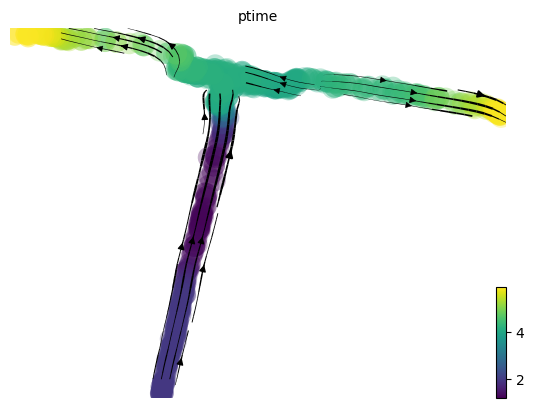

In [70]:
scv.pl.velocity_embedding_stream(adata, basis='dimred',color = 'ptime')

In [71]:
###### import scipy
scipy.stats.spearmanr(adata.obs["ptime"], adata.obs["sim_time"])

SignificanceResult(statistic=0.8416486787220002, pvalue=2.6691112931183633e-269)

In [74]:
velocity_gt = adata.layers["rna_velocity"]
velocity = adata.layers["velocity"]
import scipy
corr = scipy.stats.spearmanr(velocity_gt.todense(), velocity)
corr = np.diagonal(corr.statistic[0:208,208:(208*2)])

In [75]:
corr = corr[~np.isnan(corr)]
corr.mean()

0.16954410660830385

In [78]:
import pandas as pd
corr = pd.DataFrame(corr)
corr.to_csv("coupling_velo_corr_v3.csv")

In [89]:
GRN = rgv_m.model.lode_func.mask_m * rgv_m.model.lode_func.fc1.weight.data

In [90]:
features = [i in adata.var.index.values for i in adata.uns["regulators"]]
#W = W[features,:]
#W = W[:,features]

In [91]:
gt = adata.uns["network"]
gt = gt[features,:]
gt = gt[:,features]

In [92]:
gt = gt.T[rgv_m.model.lode_func.mask_m==1]

In [93]:
pre = GRN[rgv_m.model.lode_func.mask_m==1]

In [94]:
from scipy.spatial.distance import cdist
regulator_index = [i in adata.uns["regulators"] for i in adata.var.index.values]
target_index = [i in adata.uns["regulators"] for i in adata.var.index.values]
        
corr_m = 1 - cdist(adata.X.todense().T, adata.X.todense().T, metric='correlation')
corr_m = torch.tensor(corr_m)
#corr_m = corr_m[target_index,]
#corr_m = corr_m[:,regulator_index]
corr_m = corr_m.float()

In [95]:
pre2 = corr_m[rgv_m.model.lode_func.mask_m==1]

In [99]:
import scipy.stats as stats

# calculate Spearman correlation coefficient and p-value
corr, _ = stats.spearmanr((pre.detach().numpy()),(gt))
corr

0.45385342081195545